<a href="https://colab.research.google.com/github/ASHTONEONYANGO/Early-Prognosis-of-Cardiovascular-Diseases/blob/master/Early_Prognosis_of_Cardiovascular_Diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Heart Disease Prediction
The early prognosis of Cardiovascular Diseases can aid in making decisions on lifestyle changes in high risk patients, and in turn go a long way into reducing complications and saving lives.

This project intends to pinpoint and analyse the most relevant/risk factors of heart diseases as well as predict the overall risk using logistic regression and other allied ML technique.

In [1]:
# importing libraries
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Preparation
### Source:
The dataset is publicly available on the kaggle website, and was collected from hospitals from an ongoing study on the residents of the town of Framingham. 
The intention is to replicate the analysis from this data for high risk patients in regions across the sub-Sahara.

- https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset/data

The classification goal is to predict whether a patient has a 10-year risk of future coronary heart disease (CHD). The dataset provides the patients' information. It includes over 4,000 records and 15 attributes. 

In [4]:
heart_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Framingham.csv')
# dropping the attribute education - not much sense as a risk factor. 
# heart_df.drop(['education'],axis=1,inplace=True)
heart_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


**Renaming of columns**
- Some columns which are in complex medical terms are renamed for easy understanding by medical and non-medical persons alike.
eg. 'systolic_Blood_Pressure' is renamed to simply 'Blood_Pressure'

In [6]:
# renaming of columns for ease of understanding
heart_df.rename(columns={'male':'Gender'},inplace=True)
heart_df.rename(columns={'BPMeds':'Blood_Pressure_Medication'},inplace=True)
heart_df.rename(columns={'prevalentStroke':'stroke'},inplace=True)
heart_df.rename(columns={'prevalentHyp':'hypertension'},inplace=True)
heart_df.rename(columns={'totChol':'cholesterol'},inplace=True)
heart_df.rename(columns={'sysBP':'systolic_Blood_Pressure'},inplace=True)
heart_df.rename(columns={'diaBP':'diastolic_Blood_Pressure'},inplace=True)
#heart_df.rename(columns={'male':'Sex_male'},inplace=True)

heart_df.head()

,Gender,age,education,currentSmoker,cigsPerDay,Blood_Pressure_Medication,stroke,hypertension,diabetes,cholesterol,systolic_Blood_Pressure,diastolic_Blood_Pressure,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### Variables:

Each attribute is a potential risk factor. There are both demographic, behaviourial and medical risk factors.

- Demographic

 - Gender: male - 1 or female - 0;(Nominal)

 - age: age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)


- Behavioural

 - currentSmoker: whether or not the patient is a current smoker (Nominal)

 - cigsPerDay: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarrettes, even half a cigarette.)


- Medical Risk Factors
   
- Medical(history)

 - Blood_Pressure_Medication: whether or not the patient was on blood pressure medication (Nominal)

 - stroke: whether or not the patient had previously had a stroke (Nominal)

 - Hypertension: whether or not the patient was hypertensive (Nominal)

 - diabetes: whether or not the patient had diabetes (Nominal)


- Medical(current):

 - cholesterol: total cholesterol level (Continuous)

 - systolic_Blood_Pressure: systolic blood pressure (Continuous)

 - diastolic_Blood_Pressure: diastolic blood pressure (Continuous)

 - BMI: Body Mass Index (Continuous)

 - heartRate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)

 - glucose: glucose level (Continuous)


- Predict variable (desired target):

 - 10 year risk of coronary heart disease TenYearCHD (binary: “1”, means “Yes”, “0” means “No”)

In [9]:
count = 0
for i in heart_df.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is ', count)
print()
print('since it is only ', round((count/len(heart_df.index))*100), 'percent of the entire dataset the rows with missing values are excluded.')

Total number of rows with missing values is  582

since it is only  14 percent of the entire dataset the rows with missing values are excluded.


In [ ]:
#heart_df.dropna(axis=0,inplace=True)
# no discarding of any data
heart_df

,Gender,age,education,currentSmoker,cigsPerDay,Blood_Pressure_Medication,stroke,hypertension,diabetes,cholesterol,systolic_Blood_Pressure,diastolic_Blood_Pressure,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0


## Missing Values
- The biggest deal breakers in in data is "missing data".

In [ ]:
# identifying missing values
heart_df.isnull().sum()

Gender                         0
age                            0
education                    105
currentSmoker                  0
cigsPerDay                    29
Blood_Pressure_Medication     53
stroke                         0
hypertension                   0
diabetes                       0
cholesterol                   50
systolic_Blood_Pressure        0
diastolic_Blood_Pressure       0
BMI                           19
heartRate                      1
glucose                      388
TenYearCHD                     0
dtype: int64

Visualising the missing data.

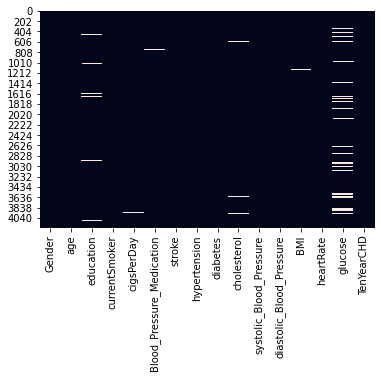

In [ ]:
# visualization off the missing values
sb.heatmap(heart_df.isnull(),cbar=False)

**Handling missing data**
#### Missing Data Imputation
- Imputing the missing data with mean.

This replaces all the null entries with the mean of the particular column

In [10]:
heart_df.education.fillna(heart_df.education.mean(),inplace=True)
heart_df.cigsPerDay.fillna(heart_df.cigsPerDay.mean(),inplace=True)
heart_df.Blood_Pressure_Medication.fillna(heart_df.Blood_Pressure_Medication.mean(),inplace=True)
heart_df.cholesterol.fillna(heart_df.cholesterol.mean(),inplace=True)
heart_df.BMI.fillna(heart_df.BMI.mean(),inplace=True)
heart_df.heartRate.fillna(heart_df.heartRate.mean(),inplace=True)
heart_df.glucose.fillna(heart_df.glucose.mean(),inplace=True)

In [11]:

heart_df.isnull().sum()

Gender                       0
age                          0
education                    0
currentSmoker                0
cigsPerDay                   0
Blood_Pressure_Medication    0
stroke                       0
hypertension                 0
diabetes                     0
cholesterol                  0
systolic_Blood_Pressure      0
diastolic_Blood_Pressure     0
BMI                          0
heartRate                    0
glucose                      0
TenYearCHD                   0
dtype: int64

- The visualization below indicates no presence of null entries in the data, all of them having been replaced with the mean values.

This is in contrast to the earlier visualisation of the missing data before imputation.

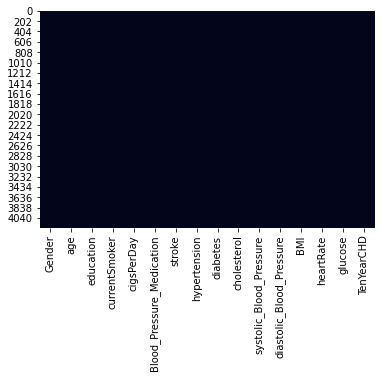

In [13]:
sb.heatmap(heart_df.isnull(),cbar=False)

**Exploratory Analysis**
### Correlation Analysis
 - Checking the correlations between columns by visualizing the correlation matrix as a heatmap ie. correlation matrix plots

In [20]:
import pandas as pd
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 7,7 
import seaborn as sns
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

Checking how one set of data corresponds to another set of data (columns) in the dataset. 

In [15]:
# correlation analysis
heart_df.corr()

,Gender,age,education,currentSmoker,cigsPerDay,Blood_Pressure_Medication,stroke,hypertension,diabetes,cholesterol,systolic_Blood_Pressure,diastolic_Blood_Pressure,BMI,heartRate,glucose,TenYearCHD
Gender,1.000000,-0.028979,0.017126,0.197596,0.316807,-0.052204,-0.004546,0.005313,0.015708,-0.069974,-0.035989,0.057933,0.081506,-0.116601,0.005818,0.088428
age,-0.028979,1.000000,-0.163613,-0.213748,-0.192366,0.121980,0.057655,0.307194,0.101258,0.260270,0.394302,0.206104,0.135283,-0.012819,0.116850,0.225256
education,0.017126,-0.163613,1.000000,0.018301,0.007962,-0.010607,-0.035110,-0.080993,-0.038146,-0.022507,-0.128260,-0.061755,-0.135635,-0.053626,-0.033721,-0.053384
currentSmoker,0.197596,-0.213748,0.018301,1.000000,0.766970,-0.048632,-0.032988,-0.103260,-0.044295,-0.046285,-0.130230,-0.107746,-0.167276,0.062348,-0.054157,0.019456
cigsPerDay,0.316807,-0.192366,0.007962,0.766970,1.000000,-0.045826,-0.032706,-0.065947,-0.037063,-0.026025,-0.088505,-0.056391,-0.092453,0.074851,-0.056088,0.057775
Blood_Pressure_Medication,-0.052204,0.121980,-0.010607,-0.048632,-0.045826,1.000000,0.115003,0.259243,0.051571,0.078909,0.252047,0.192490,0.099552,0.015175,0.048905,0.086774
stroke,-0.004546,0.057655,-0.035110,-0.032988,-0.032706,0.115003,1.000000,0.074830,0.006949,0.000067,0.057009,0.045190,0.024840,-0.017676,0.018055,0.061810
hypertension,0.005313,0.307194,-0.080993,-0.103260,-0.065947,0.259243,0.074830,1.000000,0.077808,0.163041,0.696755,0.615751,0.300572,0.147222,0.082924,0.177603
diabetes,0.015708,0.101258,-0.038146,-0.044295,-0.037063,0.051571,0.006949,0.077808,1.000000,0.040092,0.111283,0.050329,0.086250,0.048993,0.605705,0.097317
cholesterol,-0.069974,0.260270,-0.022507,-0.046285,-0.026025,0.078909,0.000067,0.163041,0.040092,1.000000,0.207609,0.163903,0.114789,0.090676,0.044583,0.081624


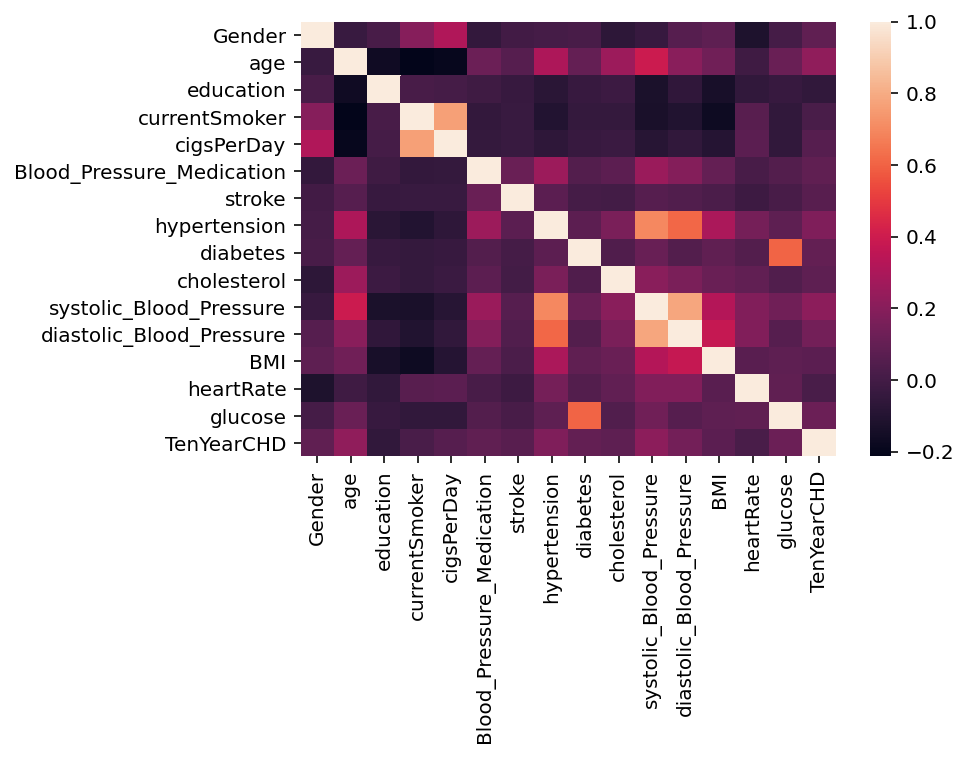

In [16]:
# matrix plot as correlation of all variables
sns.heatmap(heart_df.corr())

# there's a larger correlation magnitude towards the regions with stronger colors,aside from the diagonal

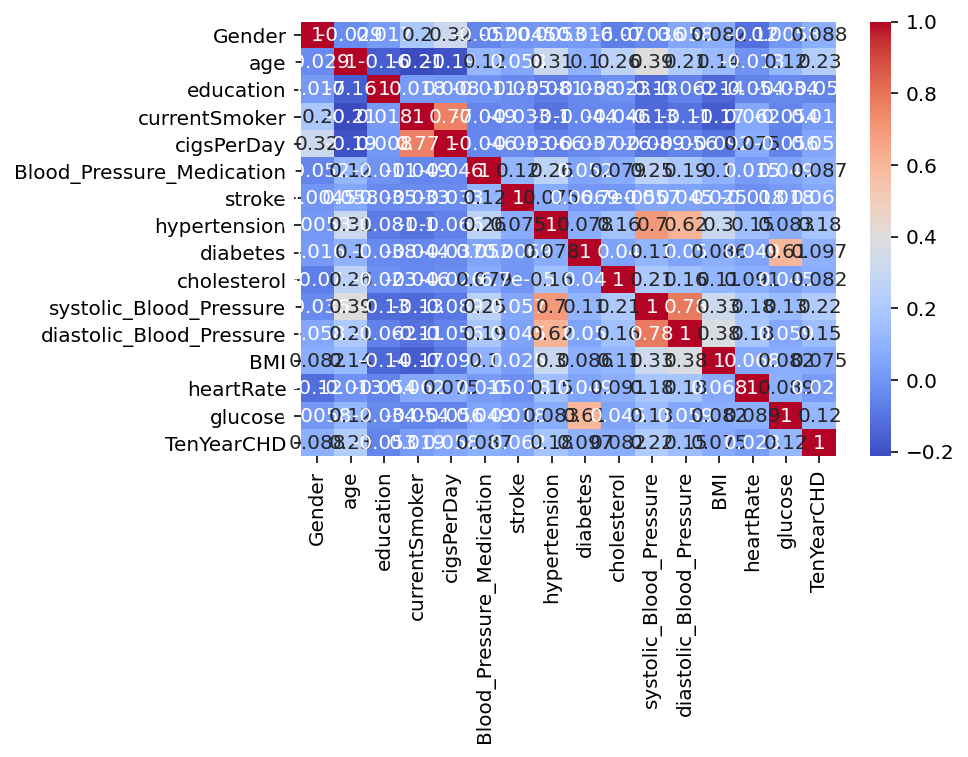

In [17]:
sns.heatmap(heart_df.corr(),cmap='coolwarm',annot=True)

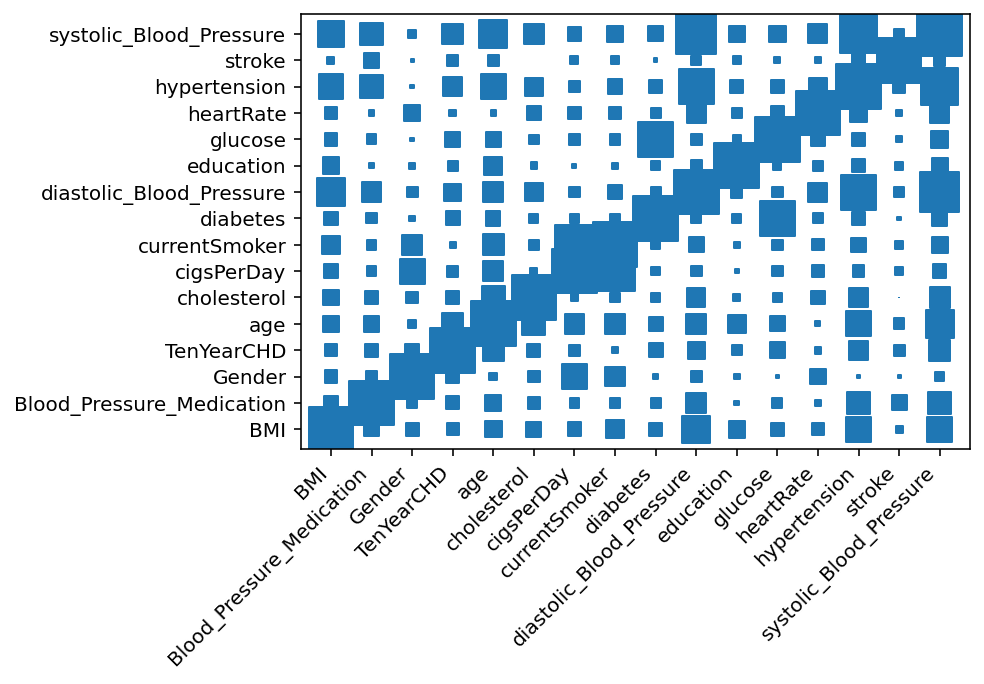

In [22]:
def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
data = heart_df
columns = ['Gender', 'age', 'education', 'currentSmoker','cigsPerDay', 'Blood_Pressure_Medication', 'stroke','hypertension','diabetes','cholesterol','systolic_Blood_Pressure','diastolic_Blood_Pressure','BMI','heartRate','glucose','TenYearCHD'] 
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

From the above plots:
- the lighter regions/color represent more positive and larger magnitude of correlation between the attributes, whereas the darker shades represent more negative and lower magnitude correlation.
- As such, systolic and diastolic blood pressure are attributed more to the prevalence of stroke and diabetes (they have a higher correlation)
- Likewise, cholesterol, glucose levels and the BMI are attributed to hypertension, diabetes and stroke.
- conversely, Gender, age and education have no significant correlation with any other attributes thus are no major medical risk factors for any health condition.

From these visualisations, it becomes very clear how systolic_Blood_Pressure, diastolic_Blood_Pressure, and hypertension play a big role in determining the occurence of TenYearCHD - coronary heart disease.

**Histograms:**
Graphical representations of the distribution of variables in a dataset. 

They show the underlying frequency or probability distribution of continuous numerical variables.

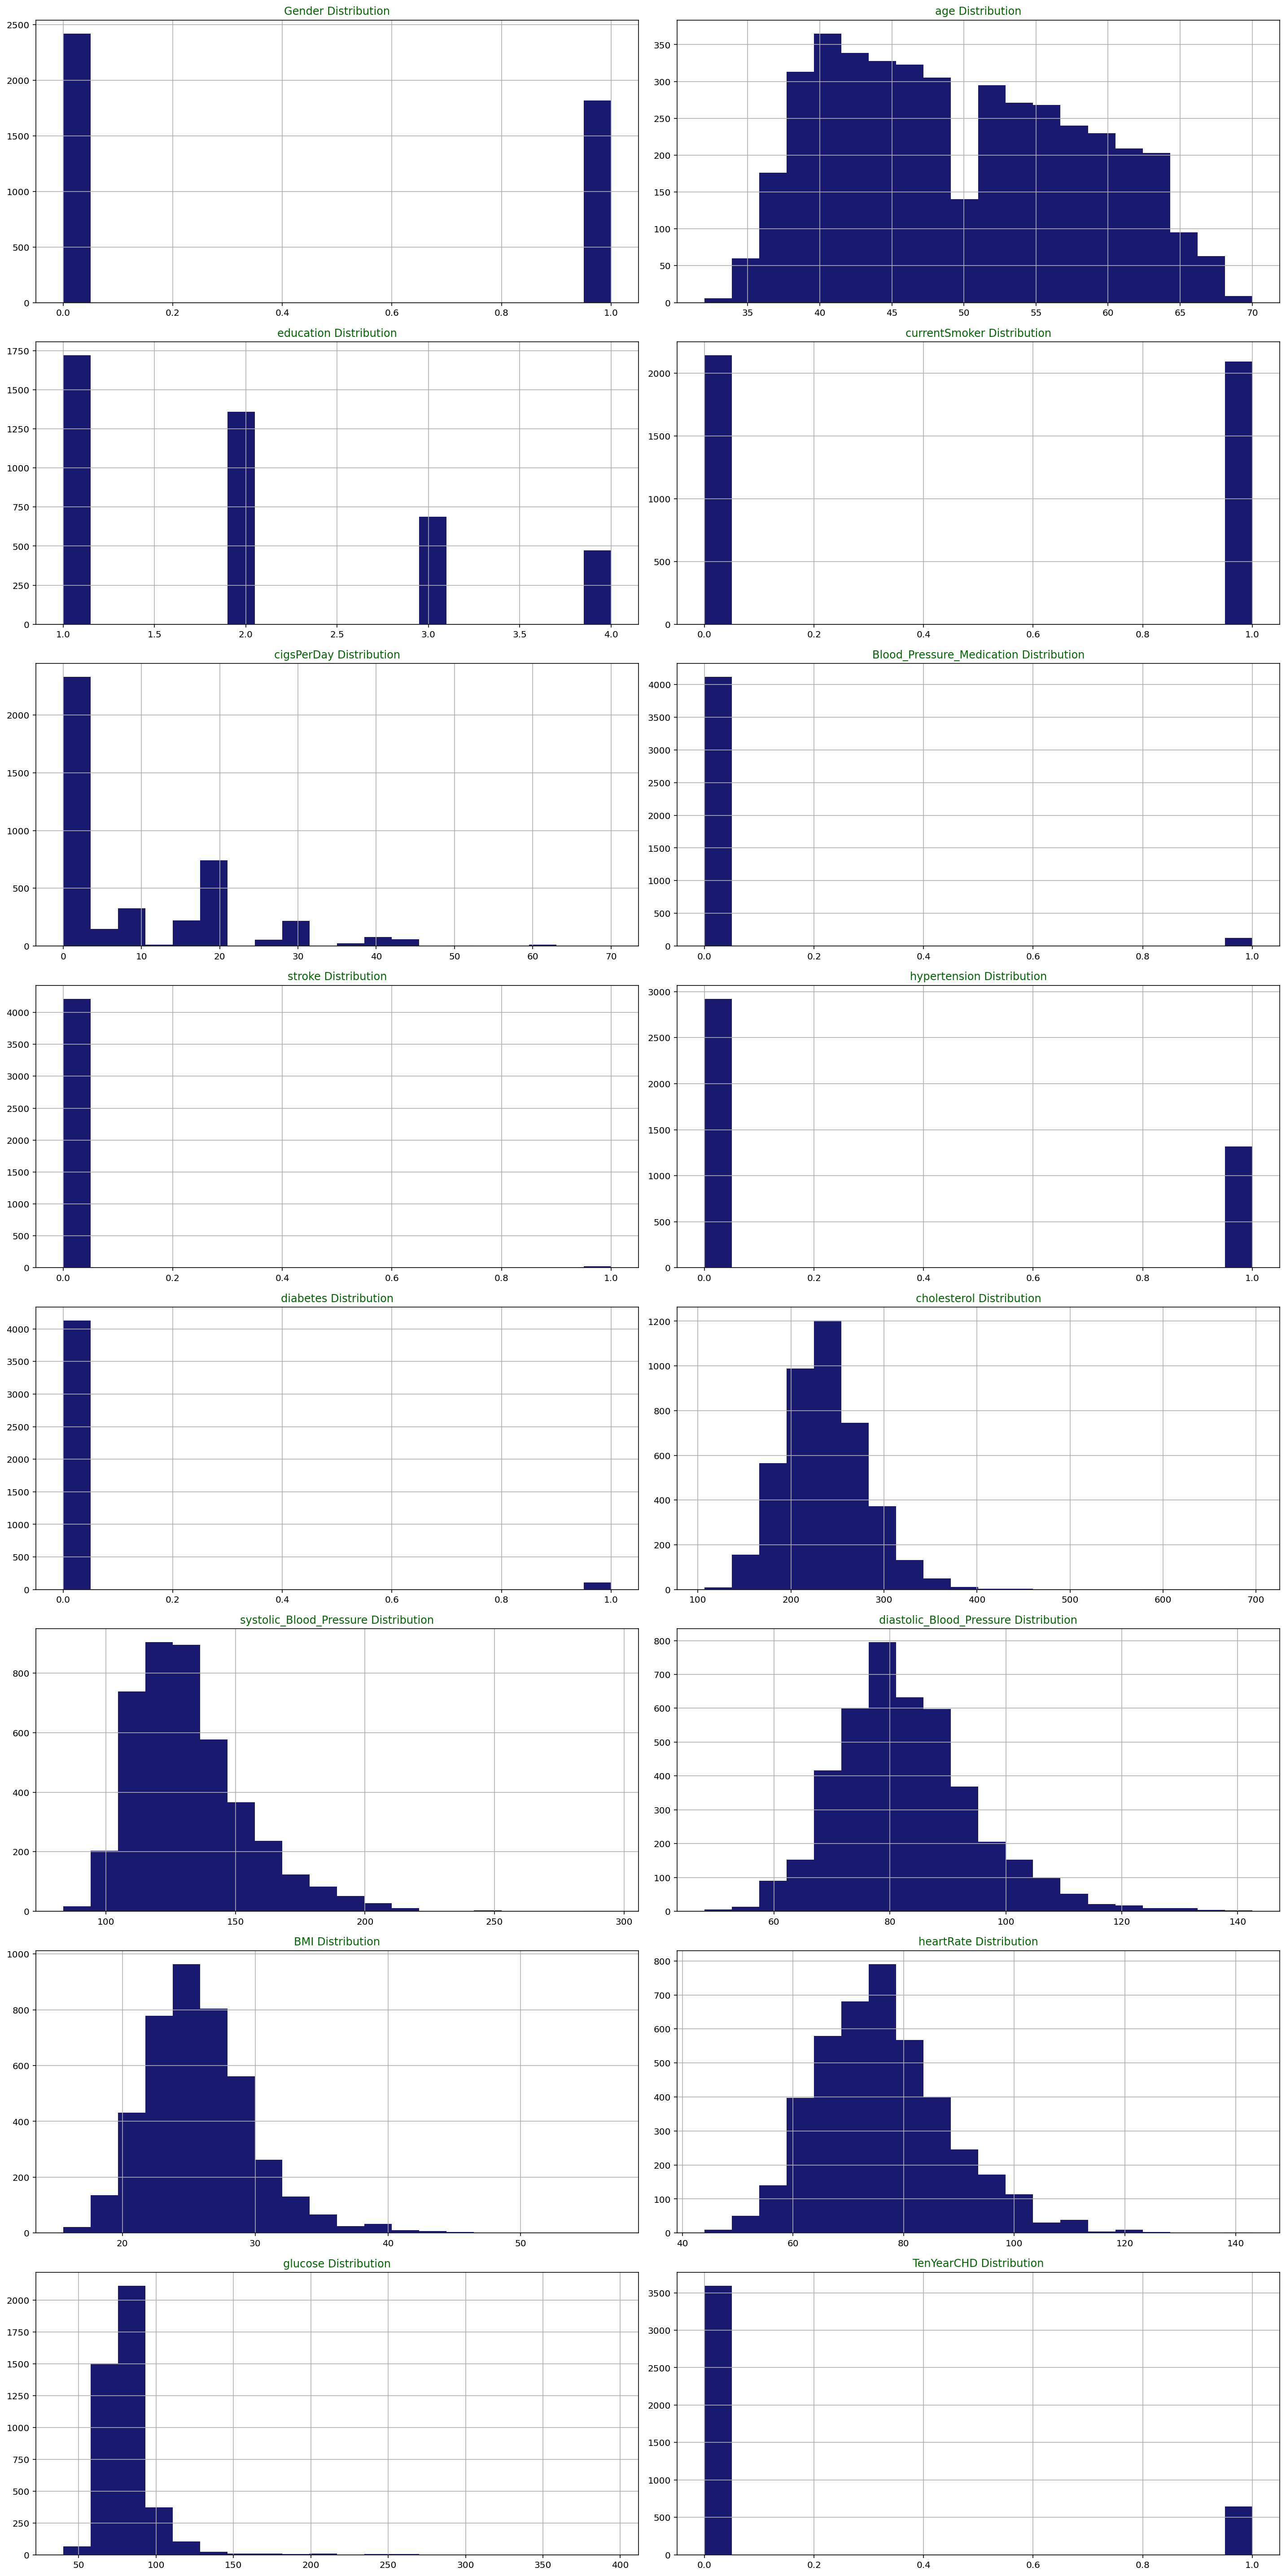

In [23]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,40))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkGreen')
    fig.tight_layout()
    plt.show()
draw_histograms(heart_df,heart_df.columns,8,2)

- In a majority of the contuinuous numerical variables distribution, the histograms are positively skewed to the right. 
- There are definitely more females than males in the study conducted in Farmingham.

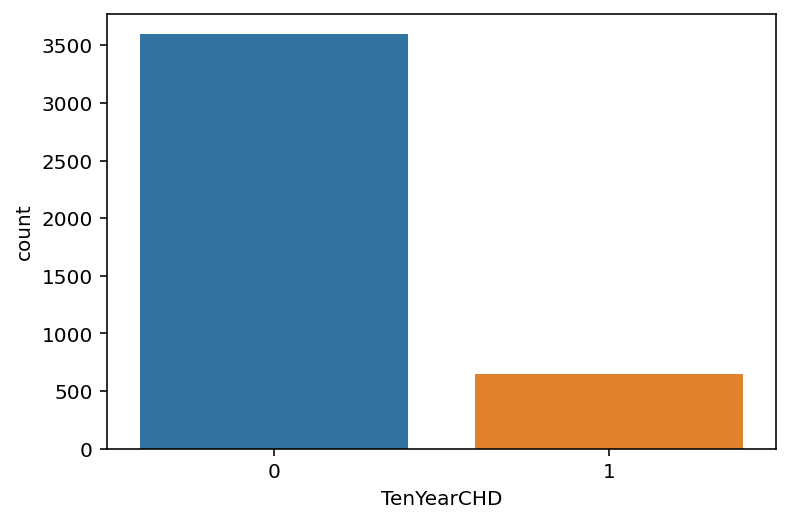

In [24]:
sns.countplot(x='TenYearCHD',data=heart_df)

In [ ]:
# matplotlib 2D visualizations
x = heart_df.cholesterol
y = heart_df.stroke

plt.plot(x,y,'r')
#plt.plot(x,y,z) 3D plot with z axis - module not attributed to the zlabel
plt.title('Test Data Plot')
plt.xlabel('Cholesterol level')
plt.ylabel('Stroke prevalence')

#plt.show()

In [ ]:
sns.heatmap(heart_df)

In [ ]:
heart_df.plot.area(alpha=0.4)

In [ ]:
sns.kdeplot(heart_df.cholesterol)
sns.rugplot(heart_df.cholesterol)

In [ ]:
sns.kdeplot(heart_df.glucose)
sns.rugplot(heart_df.glucose)

In [ ]:
sns.kdeplot(heart_df.BMI)
sns.rugplot(heart_df.BMI)

In [ ]:
sns.kdeplot(heart_df.heartRate)
sns.rugplot(heart_df.heartRate)

In [ ]:
sns.kdeplot(heart_df.age)
sns.rugplot(heart_df.age)

In [ ]:
sns.rugplot(heart_df.cholesterol)

In [ ]:
# seaborn distribution plot
sns.distplot(heart_df.age,bins=50)

In [ ]:
sns.distplot(heart_df.cholesterol,kde=False,bins=50)

In [ ]:
sns.distplot(heart_df.systolic_Blood_Pressure,kde=False,bins=100)

In [ ]:
sns.distplot(heart_df.BMI,kde=False,bins=50)

In [ ]:
sns.distplot(heart_df.heartRate,kde=False,bins=50)

In [ ]:
sns.distplot(heart_df.glucose,kde=False,bins=100)

In [ ]:
sns.barplot(x='age',y='TenYearCHD',data=heart_df)

In [ ]:
sns.barplot(x='diabetes',y='TenYearCHD',data=heart_df)

In [ ]:
sns.barplot(x='stroke',y='TenYearCHD',data=heart_df)

In [ ]:
sns.barplot(x='glucose',y='TenYearCHD',data=heart_df)

In [ ]:
sns.barplot(x='cholesterol',y='TenYearCHD',data=heart_df)

In [ ]:
sns.boxplot(data=heart_df,palette='rainbow',orient='h')

In [ ]:
sns.boxplot(x='glucose',y='hypertension',data=heart_df,palette='rainbow')

In [ ]:
sns.boxplot(x='BMI',y='TenYearCHD',hue='currentSmoker',data=heart_df,palette='coolwarm')

In [ ]:
sns.lmplot(x='glucose',y='TenYearCHD',data=heart_df,hue='Gender',palette='coolwarm',markers=['o','v'],scatter_kws={'s':100})

In [ ]:
sns.lmplot(x='cholesterol',y='glucose',data=heart_df,col='TenYearCHD')

### Multicollinearity Visualisations
- Using variable inflation factors (VIF) to determine the strength of the correlation between independent variables.

In [ ]:
# detecting multicollinearity using VIF

# importing a library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(x):
    # calculating VIF
    vif = pd.DataFrame()
    vif['variables'] = x.columns
    vif['VIF'] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    
    return(vif)

- VIF starts at 1 and has no upper limit
- VIF = 1, no  correlation between the independent variable and the other variable
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [ ]:
x = heart_df.iloc[:,:-1]
calc_vif(x)

,variables,VIF
0,Gender,2.090240
1,age,40.890138
2,education,4.746139
3,currentSmoker,4.854980
4,cigsPerDay,4.158175
5,Blood_Pressure_Medication,1.132593
6,stroke,1.025069
7,hypertension,2.387052
8,diabetes,1.566689
9,cholesterol,31.490107
